In [1]:
import sys
import os
sys.path.append(os.path.abspath("/data2/eranario/scratch/rgb-to-multispectral-unet"))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from src.dataset import PotatoDataset
from src.model import UNETR
# from src.util import show_predictions
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
# set torch random seed
torch.manual_seed(42)

# Dataset

In [4]:
rgb_dir = "/data2/eranario/data/Multispectral-Potato/Dataset/RGB_Images"
spectral_dir = "/data2/eranario/data/Multispectral-Potato/Dataset/Spectral_Images"

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

In [6]:
train_dataset = PotatoDataset(rgb_dir, spectral_dir, transform=transform, mode='train')
val_dataset = PotatoDataset(rgb_dir, spectral_dir, transform=transform, mode='val')
test_dataset = PotatoDataset(rgb_dir, spectral_dir, transform=transform, mode='test')

# print the size of the datasets
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Loading test data: 100%|██████████| 60/60 [00:00<00:00, 271.79it/s]

Train dataset size: 240
Validation dataset size: 60
Test dataset size: 60


In [7]:
batch_size = 32
num_workers = 4

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=num_workers
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=num_workers
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=num_workers
)

# Model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNETR(
    in_channels=3, 
    out_channels=len(train_dataset.channels),
    img_size=224,
    feature_size=32,
    hidden_size=32,
    mlp_dim=1024,
    num_heads=4,
    num_layers=4,
    dropout=0.1
).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training

In [9]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

num_epochs = 50
train_losses = []
val_losses = []
similarities = []  # To store SSIM scores for each epoch

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_loop = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training", leave=False)

    for batch in train_loop:
        rgb_images, *spectral_images = batch
        rgb_images = rgb_images.to(device)  # Input images
        spectral_images = torch.stack(spectral_images, dim=1).squeeze(2).to(device)  # Target spectral channels

        # Forward pass
        optimizer.zero_grad()
        outputs = model(rgb_images)
        
        # Compute loss
        loss = criterion(outputs, spectral_images)
        loss.backward()
        optimizer.step()

        # Update progress
        train_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    similarity_score = 0.0
    val_loop = tqdm(val_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Validation", leave=False)

    with torch.no_grad():
        for batch in val_loop:
            rgb_images, *spectral_images = batch
            rgb_images = rgb_images.to(device)
            spectral_images = torch.stack(spectral_images, dim=1).squeeze(2).to(device)

            outputs = model(rgb_images)
            loss = criterion(outputs, spectral_images)

            val_loss += loss.item()

            # Compute SSIM for each image in the batch
            for i in range(outputs.size(0)):  # Iterate over the batch size
                output_img = outputs[i].cpu().numpy()  # Predicted image
                groundtruth_img = spectral_images[i].cpu().numpy()  # Ground truth image

                # Normalize images to [0, 1] for SSIM computation
                output_img = (output_img - output_img.min()) / (output_img.max() - output_img.min() + 1e-8)
                groundtruth_img = (groundtruth_img - groundtruth_img.min()) / (groundtruth_img.max() - groundtruth_img.min() + 1e-8)

                # Compute SSIM for each spectral band separately
                band_ssim = [
                    ssim(output_img[band], groundtruth_img[band], data_range=1.0)  # SSIM expects normalized data
                    for band in range(output_img.shape[0])
                ]

                # Average SSIM across bands for this image
                similarity_score += np.mean(band_ssim)

            val_loop.set_postfix(loss=loss.item())
    
    avg_val_loss = val_loss / len(val_dataloader)
    avg_similarity = similarity_score / len(val_dataloader.dataset)  # Normalize over dataset size
    val_losses.append(avg_val_loss)
    similarities.append(avg_similarity)

    # Print losses and similarity for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, SSIM: {avg_similarity:.4f}")

Epoch [1/50] - Training Loss: 0.4049, Validation Loss: 0.2303, SSIM: 0.0399


Epoch [2/50] - Training Loss: 0.0897, Validation Loss: 0.0835, SSIM: 0.1088


Epoch [3/50] - Training Loss: 0.0536, Validation Loss: 0.0633, SSIM: 0.1254


Epoch [4/50] - Training Loss: 0.0431, Validation Loss: 0.0407, SSIM: 0.1349


Epoch [5/50] - Training Loss: 0.0397, Validation Loss: 0.0368, SSIM: 0.1307


Epoch [6/50] - Training Loss: 0.0384, Validation Loss: 0.0360, SSIM: 0.1260


Epoch [7/50] - Training Loss: 0.0377, Validation Loss: 0.0350, SSIM: 0.1225


Epoch [8/50] - Training Loss: 0.0368, Validation Loss: 0.0345, SSIM: 0.1271


Epoch [9/50] - Training Loss: 0.0366, Validation Loss: 0.0342, SSIM: 0.1263


Epoch [10/50] - Training Loss: 0.0360, Validation Loss: 0.0339, SSIM: 0.1291


Epoch [11/50] - Training Loss: 0.0358, Validation Loss: 0.0337, SSIM: 0.1284


Epoch [12/50] - Training Loss: 0.0357, Validation Loss: 0.0336, SSIM: 0.1279


Epoch [13/50] - Training Loss: 0.0355, Validation Loss: 0.0334, SSIM: 0.1266


Epoch [14/50] - Training Loss: 0.0355, Validation Loss: 0.0333, SSIM: 0.1287


Epoch [15/50] - Training Loss: 0.0350, Validation Loss: 0.0331, SSIM: 0.1280


Epoch [16/50] - Training Loss: 0.0353, Validation Loss: 0.0330, SSIM: 0.1307


Epoch [17/50] - Training Loss: 0.0351, Validation Loss: 0.0329, SSIM: 0.1293


Epoch [18/50] - Training Loss: 0.0350, Validation Loss: 0.0328, SSIM: 0.1297


Epoch [19/50] - Training Loss: 0.0347, Validation Loss: 0.0327, SSIM: 0.1294


Epoch [20/50] - Training Loss: 0.0348, Validation Loss: 0.0326, SSIM: 0.1302


Epoch [21/50] - Training Loss: 0.0343, Validation Loss: 0.0325, SSIM: 0.1312


Epoch [22/50] - Training Loss: 0.0345, Validation Loss: 0.0325, SSIM: 0.1303


Epoch [23/50] - Training Loss: 0.0344, Validation Loss: 0.0325, SSIM: 0.1303


Epoch [24/50] - Training Loss: 0.0345, Validation Loss: 0.0324, SSIM: 0.1311


Epoch [25/50] - Training Loss: 0.0343, Validation Loss: 0.0323, SSIM: 0.1316


Epoch [26/50] - Training Loss: 0.0343, Validation Loss: 0.0323, SSIM: 0.1318


Epoch [27/50] - Training Loss: 0.0342, Validation Loss: 0.0322, SSIM: 0.1330


Epoch [28/50] - Training Loss: 0.0341, Validation Loss: 0.0322, SSIM: 0.1334


Epoch [29/50] - Training Loss: 0.0341, Validation Loss: 0.0321, SSIM: 0.1340


Epoch [30/50] - Training Loss: 0.0341, Validation Loss: 0.0322, SSIM: 0.1337


Epoch [31/50] - Training Loss: 0.0339, Validation Loss: 0.0320, SSIM: 0.1342


Epoch [32/50] - Training Loss: 0.0341, Validation Loss: 0.0320, SSIM: 0.1337


Epoch [33/50] - Training Loss: 0.0339, Validation Loss: 0.0320, SSIM: 0.1344


Epoch [34/50] - Training Loss: 0.0337, Validation Loss: 0.0319, SSIM: 0.1352


Epoch [35/50] - Training Loss: 0.0337, Validation Loss: 0.0319, SSIM: 0.1342


Epoch [36/50] - Training Loss: 0.0339, Validation Loss: 0.0320, SSIM: 0.1349


Epoch [37/50] - Training Loss: 0.0342, Validation Loss: 0.0319, SSIM: 0.1340


Epoch [38/50] - Training Loss: 0.0343, Validation Loss: 0.0319, SSIM: 0.1343


Epoch [39/50] - Training Loss: 0.0339, Validation Loss: 0.0319, SSIM: 0.1335


Epoch [40/50] - Training Loss: 0.0339, Validation Loss: 0.0318, SSIM: 0.1344


Epoch [41/50] - Training Loss: 0.0336, Validation Loss: 0.0318, SSIM: 0.1346


Epoch [42/50] - Training Loss: 0.0337, Validation Loss: 0.0318, SSIM: 0.1346


Epoch [43/50] - Training Loss: 0.0339, Validation Loss: 0.0318, SSIM: 0.1340


Epoch [44/50] - Training Loss: 0.0340, Validation Loss: 0.0318, SSIM: 0.1336


Epoch [45/50] - Training Loss: 0.0336, Validation Loss: 0.0317, SSIM: 0.1347


Epoch [46/50] - Training Loss: 0.0337, Validation Loss: 0.0317, SSIM: 0.1351


Epoch [47/50] - Training Loss: 0.0336, Validation Loss: 0.0318, SSIM: 0.1350


Epoch [48/50] - Training Loss: 0.0336, Validation Loss: 0.0317, SSIM: 0.1349


Epoch [49/50] - Training Loss: 0.0335, Validation Loss: 0.0317, SSIM: 0.1365


Epoch [50/50] - Training Loss: 0.0339, Validation Loss: 0.0316, SSIM: 0.1361


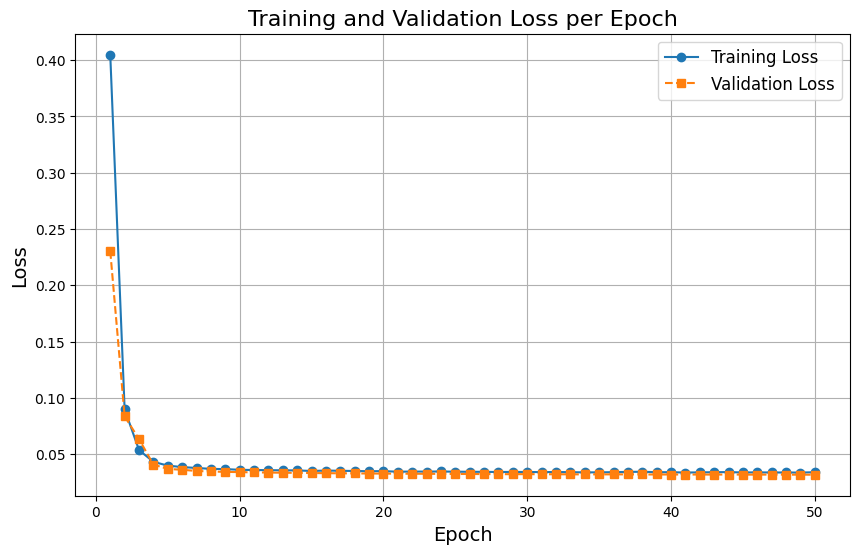

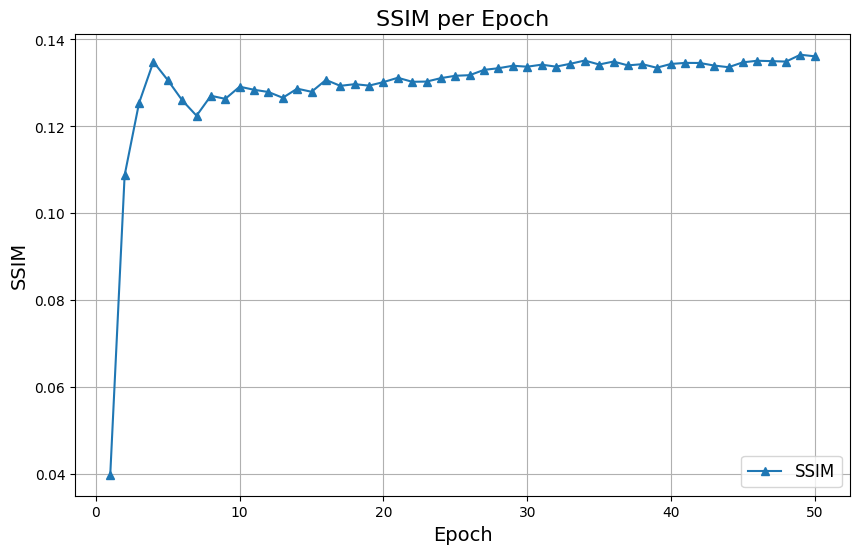

In [10]:
# Plotting training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, marker='s', linestyle='--', label="Validation Loss")
plt.title("Training and Validation Loss per Epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# Plotting similarity metric
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), similarities, marker='^', linestyle='-', label="SSIM")
plt.title("SSIM per Epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("SSIM", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

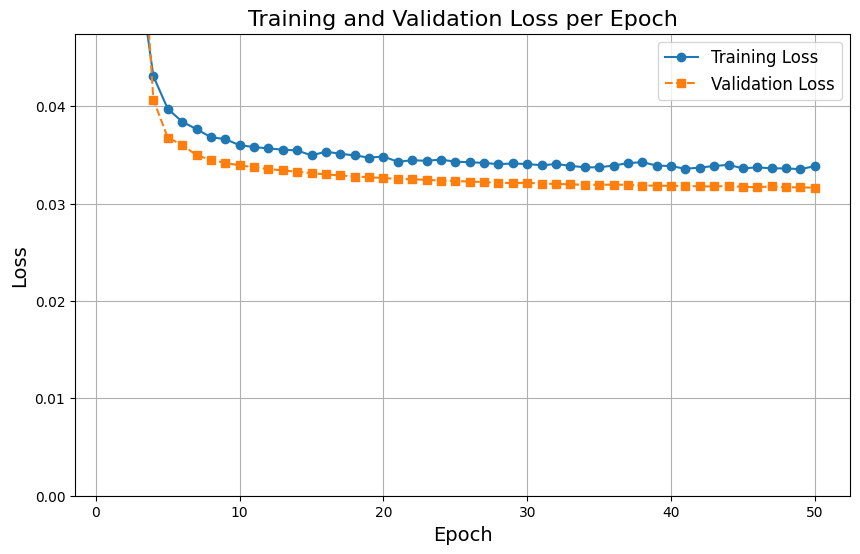

In [11]:
# Plotting training and validation loss curves with zoomed y-axis
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, marker='s', linestyle='--', label="Validation Loss")
plt.title("Training and Validation Loss per Epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)

# Adjust y-axis limits to zoom in
min_loss = min(min(train_losses), min(val_losses))
plt.ylim(0, min_loss * 1.5)  # Set upper limit slightly above the minimum loss for better visibility

plt.show()

In [12]:
def show_predictions(dataloader, model, device, channels=None):
    """
    Displays the RGB input, ground truth spectral channels, and model predictions for a single sample in a vertical layout.
    Args:
        dataloader: DataLoader to fetch data.
        model: Trained model to generate predictions.
        device: Device (CPU/GPU) to use.
        channels: List of channel names (e.g., ['Green', 'NIR', 'Red', 'Red Edge']).
    """
    model.eval()  # Set model to evaluation mode

    channels = channels or ['Green', 'NIR', 'Red', 'Red Edge']  # Default channel names
    num_spectral_channels = len(channels)

    # Get one batch of data
    rgb_images, *spectral_images = next(iter(dataloader))
    rgb_images = rgb_images.to(device)  # Move RGB inputs to the device
    spectral_images = torch.stack(spectral_images, dim=1).squeeze(2).to(device)  # Ground truth
    predictions = model(rgb_images)  # Model predictions

    # Use only the first sample in the batch
    rgb_image = rgb_images[1].permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC for RGB
    ground_truth = spectral_images[1].cpu().numpy()  # (num_channels, H, W)
    prediction = predictions[1].detach().cpu().numpy()  # Detach, then convert to NumPy (num_channels, H, W)

    # Create a vertical layout figure
    fig, axs = plt.subplots(num_spectral_channels, 3, figsize=(15, 5 * num_spectral_channels))
    for channel_idx in range(num_spectral_channels):
        spectral_channel_gt = ground_truth[channel_idx]  # Ground truth for this channel
        spectral_channel_pred = prediction[channel_idx]  # Prediction for this channel

        # RGB input
        if channel_idx == 0:  # Show RGB only in the first row
            axs[channel_idx, 0].imshow(rgb_image)
            axs[channel_idx, 0].set_title("RGB Input")
        else:
            axs[channel_idx, 0].axis("off")  # Keep empty for other rows

        # Ground truth
        axs[channel_idx, 1].imshow(spectral_channel_gt, cmap="viridis")
        axs[channel_idx, 1].set_title(f"GT: {channels[channel_idx]}")

        # Prediction
        axs[channel_idx, 2].imshow(spectral_channel_pred, cmap="viridis")
        axs[channel_idx, 2].set_title(f"Pred: {channels[channel_idx]}")

        # Remove axes for cleaner visualization
        axs[channel_idx, 0].axis("off")
        axs[channel_idx, 1].axis("off")
        axs[channel_idx, 2].axis("off")

    plt.tight_layout()
    plt.show()

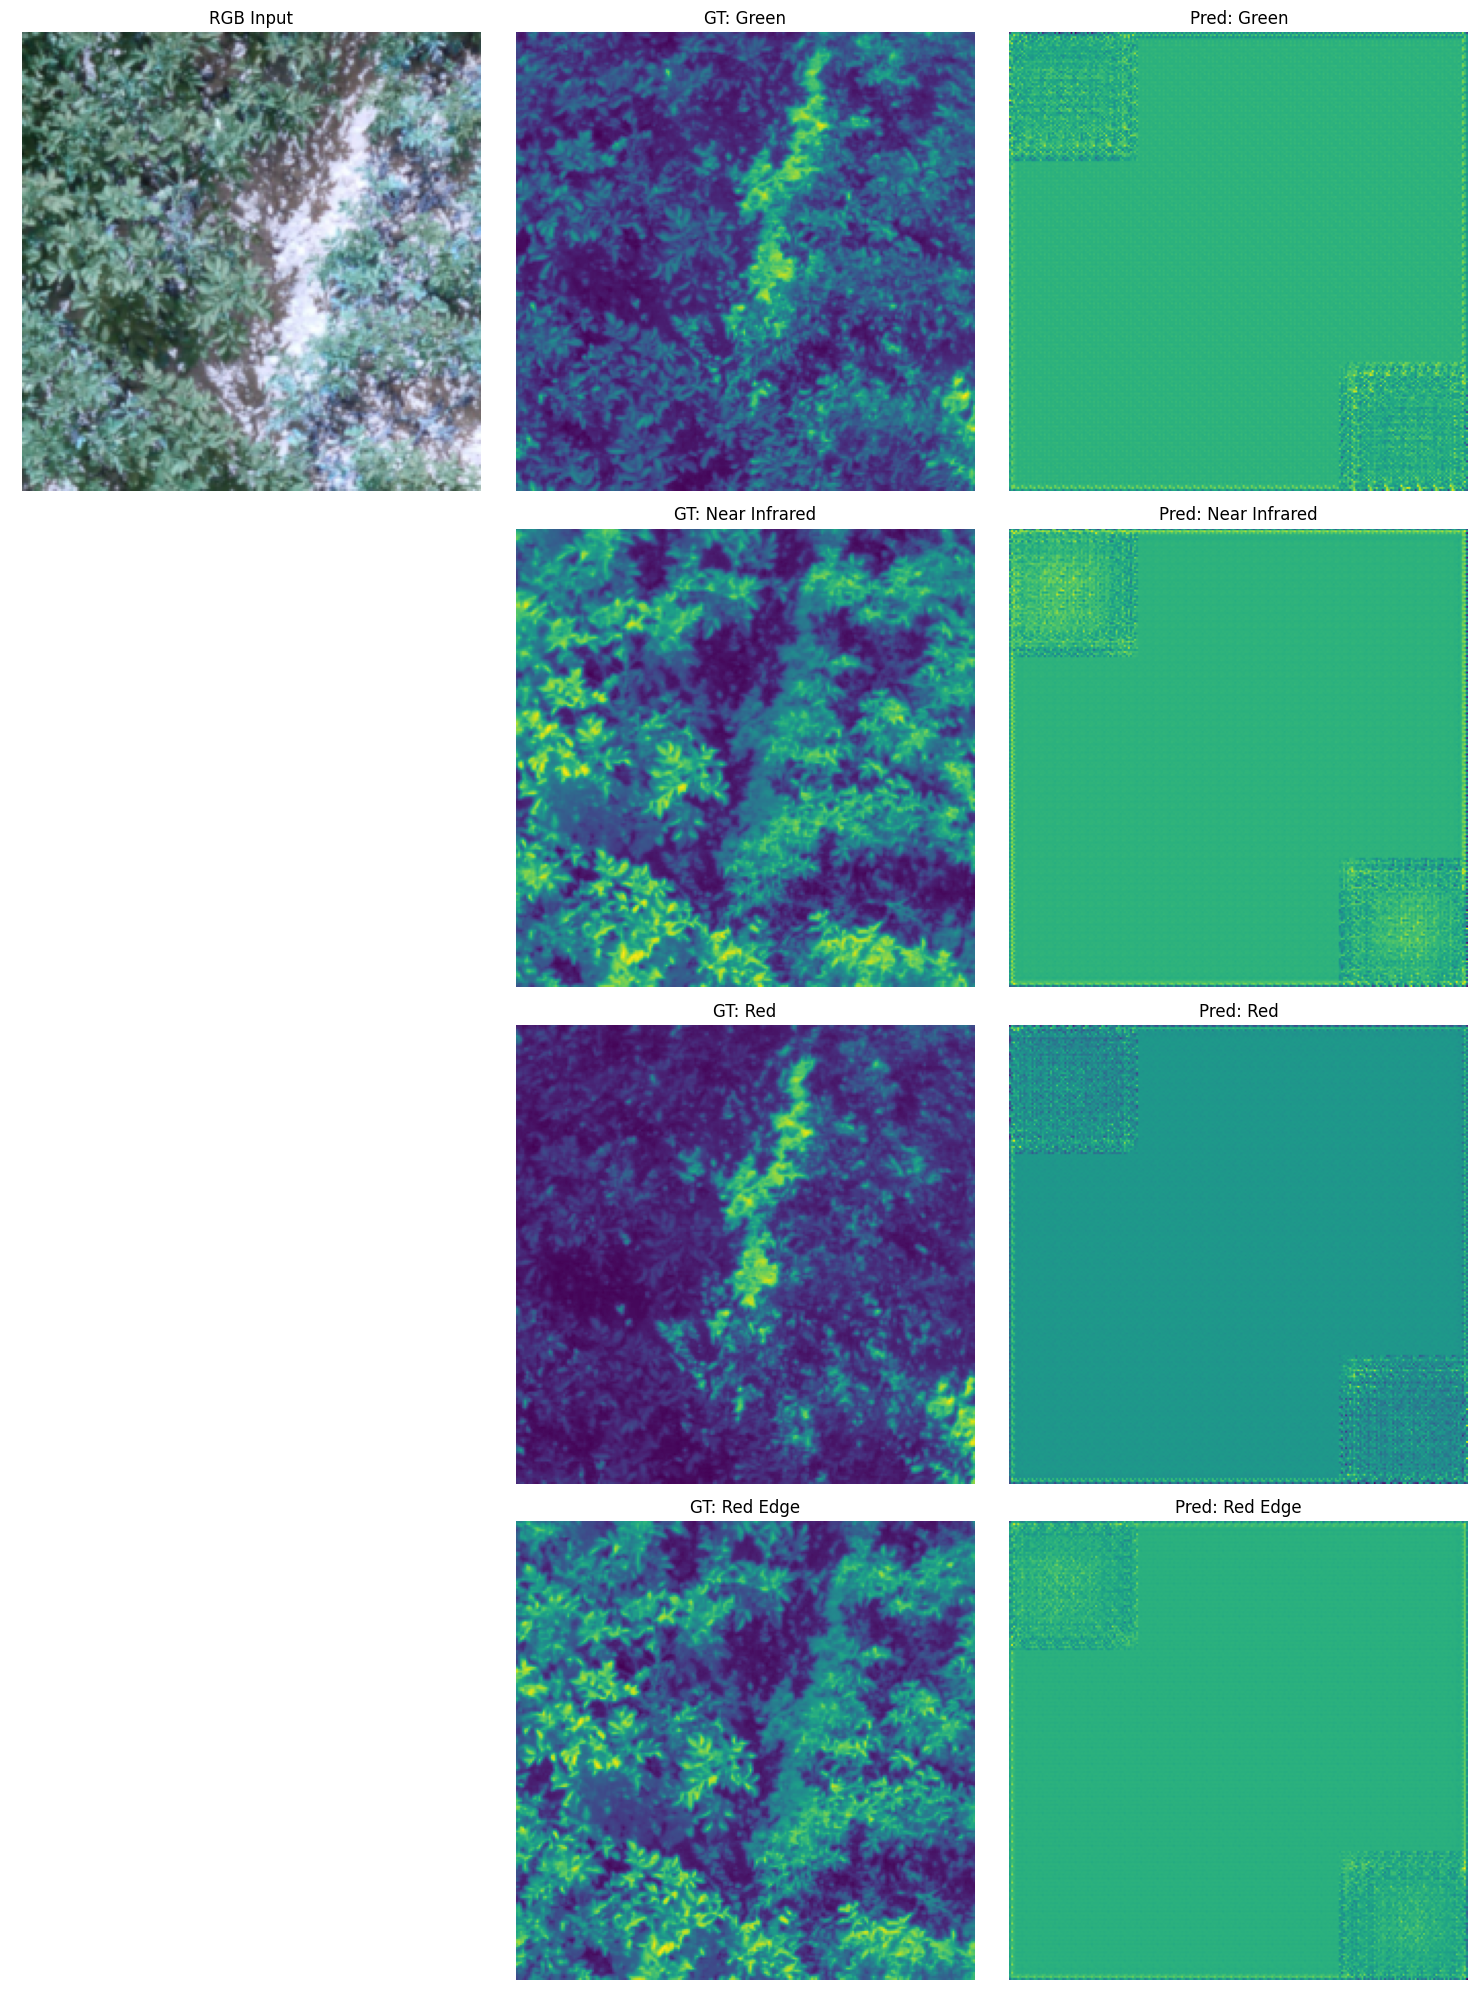

In [13]:
channels = ['Green', 'Near Infrared', 'Red', 'Red Edge']
show_predictions(test_dataloader, model, device, channels=channels)